In [1]:
# Import the libraries we will be using
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns
from scipy.spatial import distance
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.model_selection import cross_val_score
from collections import defaultdict

import sys
sys.path.append("..")


sns.set(font_scale=1.5)

In [2]:
# Import the ratings dataset
df_ratings = pd.read_csv('./ratings.csv')
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [3]:

# Import movies dataset
df_movies = pd.read_csv('./movies.csv')
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
print('The dataset contains: ', len(df_ratings), ' ratings of ', len(df_movies), ' movies.')

The dataset contains:  100836  ratings of  9742  movies.


In [5]:
# Replace name of ""(no genres listed)" with "NA"
df_movies.genres = df_movies.genres.replace("(no genres listed)", "NA")
# Counts per genre (films may appear in more than one genre)
pd.Series(df_movies.genres.str.cat(sep="|").split("|")).value_counts()

Drama          4361
Comedy         3756
Thriller       1894
Action         1828
Romance        1596
Adventure      1263
Crime          1199
Sci-Fi          980
Horror          978
Fantasy         779
Children        664
Animation       611
Mystery         573
Documentary     440
War             382
Musical         334
Western         167
IMAX            158
Film-Noir        87
NA               34
dtype: int64

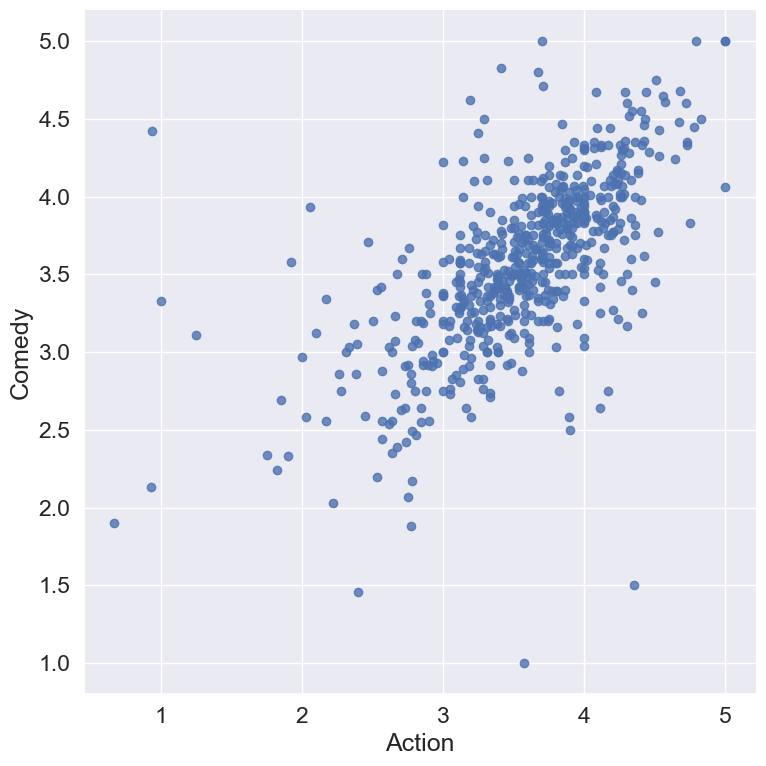

In [6]:
#Feature representation
#How can we turn these ratings into a useful representation of user tastes (i.e., features)?
#Avg. Ratings
#One way is to define each feature vector as movie ratings or average genre rating. Let's start with genre.

def get_genre_ratings(ratings, movies, genres, mean=True):
    all_genre_df = pd.DataFrame()
    for genre in genres:        
        genre_movies = movies[movies['genres'].str.contains(genre)]
        relevant_ratings = ratings[ratings['movieId'].isin(genre_movies['movieId'])]
        if mean is True:
            single_genre_df = relevant_ratings.groupby(['userId'])['rating'].mean().round(2)
        else:
            single_genre_df = relevant_ratings.groupby(['userId'])['rating'].count()
        all_genre_df = pd.concat([all_genre_df, single_genre_df], axis=1)
    all_genre_df.columns = genres
    return all_genre_df

genres = ['Action', 'Comedy']
users_by_avg_genre_ratings = get_genre_ratings(df_ratings, df_movies, genres)
sns.lmplot(users_by_avg_genre_ratings, x = genres[0], y = genres[1], fit_reg=False, height = 8)
plt.show()

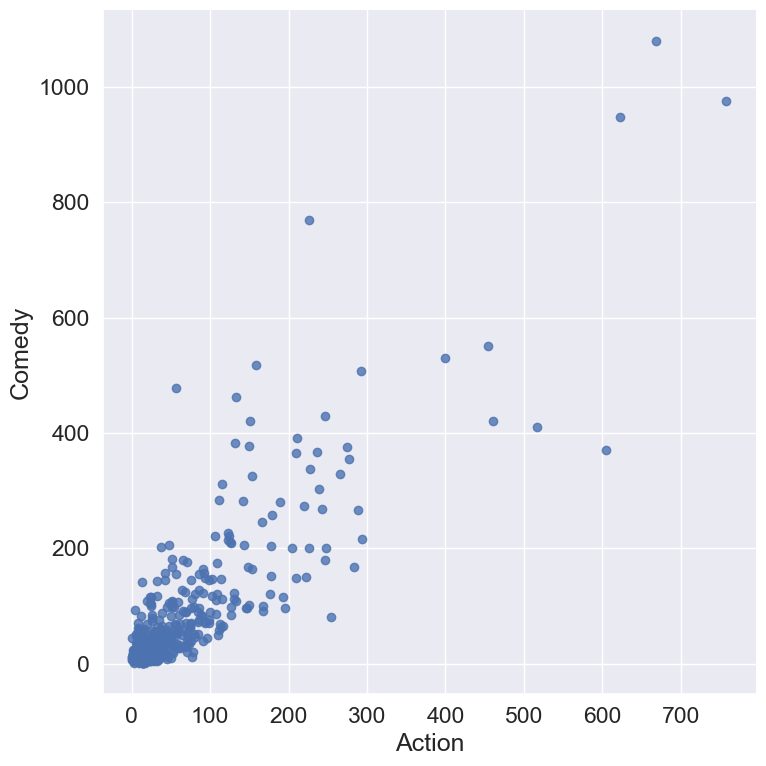

In [7]:
#All genre ratings seem to be positively correlated. What's going on?
#Number of ratings
#Let's try as features the total numbers of movies of each genre that users have rated.

genres = ['Action', 'Comedy']
users_by_total_genre_ratings = get_genre_ratings(df_ratings, df_movies, genres, False)
sns.lmplot( data=users_by_total_genre_ratings, x = genres[0], y = genres[1],fit_reg=False, height=8)
plt.show()

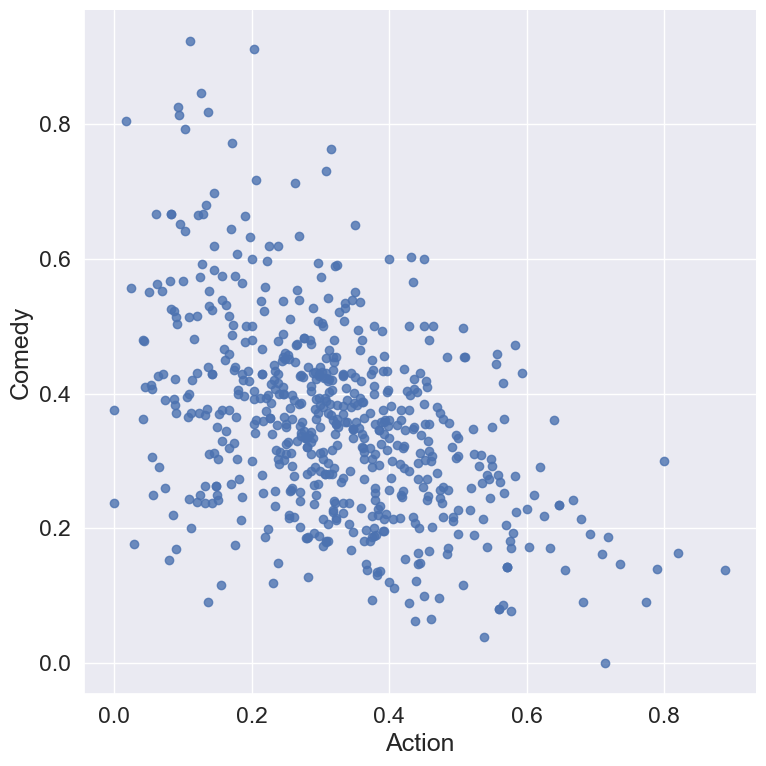

In [8]:
#Still everything seems correlated, why?
#Percentage of ratings
#What if we instead define the feature vector as the percentage of ratings belonging to each genre?

def get_genre_shares(ratings, movies):
    all_genres = np.unique(df_movies.genres.str.cat(sep="|").split("|"))
    all_genre_df = pd.DataFrame()
    for genre in all_genres:
        genre_movies = movies[movies['genres'].str.contains(genre)]
        relevant_ratings = ratings[ratings['movieId'].isin(genre_movies['movieId'])]
        single_genre_df = relevant_ratings.loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].count()
        all_genre_df = pd.concat([all_genre_df, single_genre_df], axis=1)
    # Get shares
    all_genre_df.columns = all_genres
    all_genre_df.fillna(0, inplace=True)
    all_genre_df = all_genre_df.div(ratings.groupby('userId').rating.count(), axis=0)
    return all_genre_df

genres = ['Action', 'Comedy']
users_by_rating_per = get_genre_shares(df_ratings, df_movies)
sns.lmplot( data=users_by_rating_per, x = genres[0], y = genres[1],fit_reg=False, height=8)
plt.show()

In [9]:
#Similarity measures
#Once we have objects described as data, we can compute the similarity between different objects. 
#Each of the users is now described by their tastes for different genres. 
#Let's keep the share of ratings representation for now.
users_by_rating_per.head(5)

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,NA,Romance,Sci-Fi,Thriller,War,Western
1,0.387931,0.366379,0.125000,0.181034,0.357759,0.193966,0.000000,0.293103,0.202586,0.004310,0.073276,0.000000,0.094828,0.077586,0.0,0.112069,0.172414,0.237069,0.094828,0.030172
2,0.379310,0.103448,0.000000,0.000000,0.241379,0.344828,0.103448,0.586207,0.000000,0.000000,0.034483,0.137931,0.000000,0.068966,0.0,0.034483,0.137931,0.344828,0.034483,0.034483
3,0.358974,0.282051,0.102564,0.128205,0.230769,0.051282,0.000000,0.410256,0.102564,0.000000,0.205128,0.000000,0.025641,0.025641,0.0,0.128205,0.384615,0.179487,0.128205,0.000000
4,0.115741,0.134259,0.027778,0.046296,0.481481,0.125000,0.009259,0.555556,0.087963,0.018519,0.018519,0.004630,0.074074,0.106481,0.0,0.268519,0.055556,0.175926,0.032407,0.046296
5,0.204545,0.181818,0.136364,0.204545,0.340909,0.272727,0.000000,0.568182,0.159091,0.000000,0.022727,0.068182,0.113636,0.022727,0.0,0.250000,0.045455,0.204545,0.068182,0.045455


In [10]:
#Here is a function that will compute the distance (between users) using as many metrics as you want:

def user_distance(users, userId, distance_measures, n):
    # We want a data frame to store the output
    # distance_measures is a list of the distance measures you want to compute (see below)
    # n is how many "most similar" to report
    distances = pd.DataFrame()
    # Find the location of the whiskey we are looking for
    user_location = np.where(users.index == userId)[0][0]
    # Go through all distance measures we care about
    for distance_measure in distance_measures:
        # Find all pairwise distances
        current_distances = distance.squareform(distance.pdist(users, distance_measure))
        # Get the closest n elements for the user we care about
        most_similar = np.argsort(current_distances[:, user_location])[0:n]
        # Append results (a new column to the dataframe with the name of the measure)
        distances[distance_measure] = list(zip(users.index[most_similar], current_distances[most_similar, user_location]))
    return distances
#We can use the function user_distance to find the distance value of each user with respect to others. 
#We'll start using Euclidean distance as our metric:

user_distance(users_by_rating_per, 1, ['euclidean'], 6)

,euclidean
0,"(1, 0.0)"
1,"(63, 0.17709559247252601)"
2,"(328, 0.18049125683427292)"
3,"(230, 0.1911339598809096)"
4,"(212, 0.19158200188198352)"
5,"(559, 0.1954084262054854)"


In [11]:
#Now, let's use more meatrics.

user_distance(users_by_rating_per, 1, ['euclidean', 'cityblock', 'cosine', 'correlation'], 10)

,euclidean,cityblock,cosine,correlation
0,"(1, 0.0)","(1, 0.0)","(1, 0.0)","(1, 0.0)"
1,"(63, 0.17709559247252601)","(328, 0.5777045300878971)","(63, 0.02007259654154714)","(63, 0.04716732663905232)"
2,"(328, 0.18049125683427292)","(212, 0.5998331479421579)","(328, 0.020879378014717953)","(67, 0.04774478550878691)"
3,"(230, 0.1911339598809096)","(478, 0.6242163009404389)","(230, 0.02286313548795038)","(559, 0.05127801917479913)"
4,"(212, 0.19158200188198352)","(63, 0.6383604784323705)","(212, 0.02303528954305223)","(328, 0.05275220925130808)"
5,"(559, 0.1954084262054854)","(230, 0.6507380302654427)","(559, 0.024611787474057678)","(212, 0.05312075731053223)"
6,"(478, 0.20577772020068938)","(308, 0.6938905547226386)","(382, 0.026287795853424334)","(230, 0.05577719318647034)"
7,"(240, 0.2074993603640772)","(559, 0.6979064039408868)","(478, 0.026535197553908874)","(382, 0.05859047293540853)"
8,"(382, 0.20955448226960666)","(217, 0.726099735613433)","(67, 0.026811159912045412)","(217, 0.06241298973945397)"
9,"(592, 0.2127416253764623)","(171, 0.7265559293523969)","(394, 0.02808036514621126)","(592, 0.06264741383518524)"


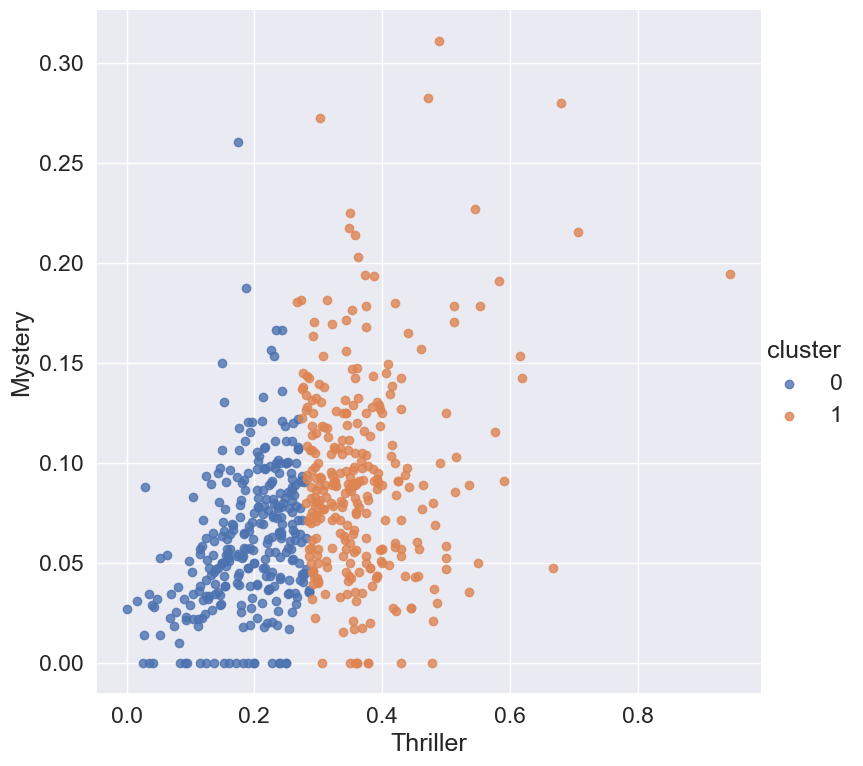

In [12]:
# KMeans: Another method for finding clusters is to use the KMeans algorithm to find a set of 𝑘 k
# clusters. Here, unlike in hierarchical clustering, we define the number of clusters in advance. 
# We'll use the library sklearn.cluster

k_clusters = 2
kmeans = KMeans(n_clusters=k_clusters, random_state=42)
genres = ['Thriller', 'Mystery']
kmeans.fit(users_by_rating_per[genres])
users_by_rating_per['cluster'] = kmeans.predict(users_by_rating_per[genres])
sns.lmplot( data=users_by_rating_per, x = genres[0], y = genres[1],hue='cluster', fit_reg=False, height=8)
plt.show()

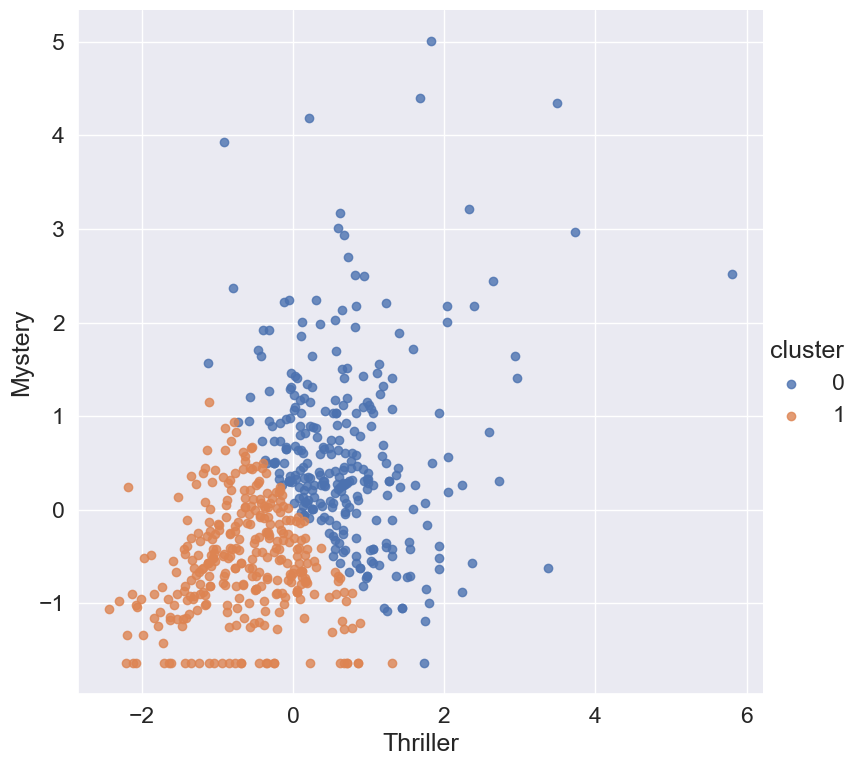

In [14]:
df_normalized_genre = (users_by_rating_per - users_by_rating_per.mean())/users_by_rating_per.std()
k_clusters = 2
kmeans = KMeans(n_clusters=k_clusters, random_state=42)

genres = ['Thriller', 'Mystery']
kmeans.fit(df_normalized_genre[genres])
df_normalized_genre['cluster'] = kmeans.predict(df_normalized_genre[genres])
sns.lmplot( data=df_normalized_genre, x = genres[0], y = genres[1],hue='cluster', fit_reg=False, height=8)
plt.show()

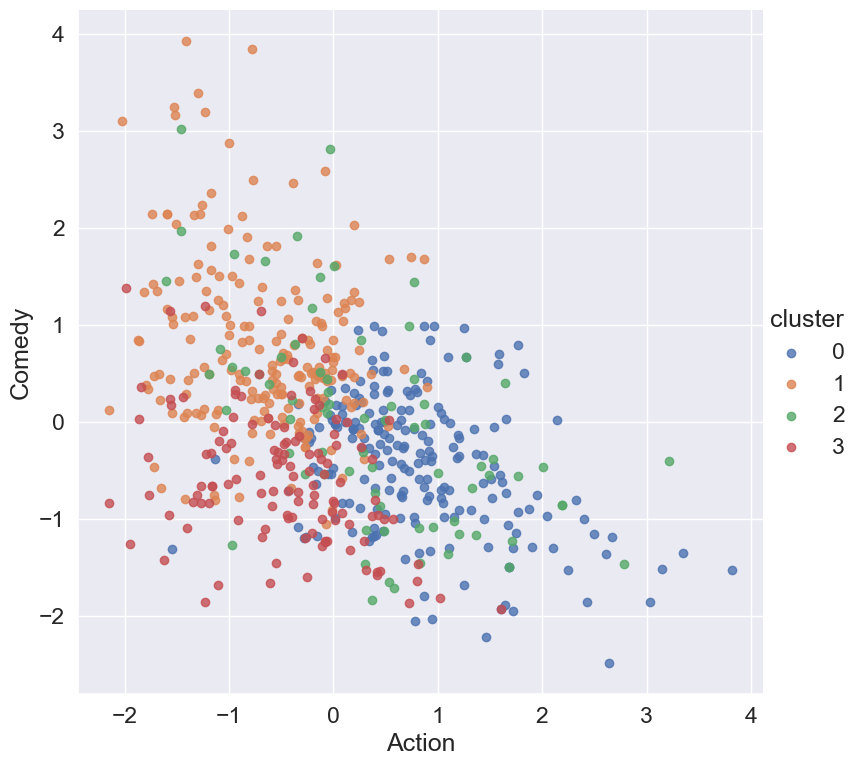

In [16]:
kmeans = KMeans(n_clusters=4, random_state=42)
#kmeans.fit(users_by_rating_per[genres])
#kmeans.fit(users_by_rating_per[genres])
all_genres = df_normalized_genre.columns[df_normalized_genre.columns != 'cluster']
genres = ['Action', 'Comedy']
df_normalized_genre['cluster'] = kmeans.fit_predict(df_normalized_genre[all_genres]).astype(int)
sns.lmplot( data=df_normalized_genre, x = genres[0], y = genres[1], hue='cluster', fit_reg=False, height=8)
plt.show()

In [17]:
centroids = df_normalized_genre.groupby('cluster').mean()
centroids

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,NA,Romance,Sci-Fi,Thriller,War,Western
cluster,,,,,,,,,,,,,,,,,,,,
0,0.809631,0.456467,-0.225293,-0.252593,-0.427190,0.175987,-0.222671,-0.391321,-0.122523,-0.210109,0.295830,0.085495,-0.270579,-0.052389,-0.107336,-0.557005,0.636107,0.637430,0.090150,0.081590
1,-0.667431,-0.499254,-0.074904,0.093036,0.785591,-0.470777,-0.053575,0.043593,-0.088222,-0.204869,-0.129848,-0.379723,0.395025,-0.442646,-0.089127,0.821813,-0.552026,-0.596973,-0.245002,0.093132
2,0.372624,1.429450,1.732187,1.550481,-0.026760,-0.728362,-0.087290,-0.757631,1.526812,-0.361587,-0.300447,1.233195,0.572740,-0.261637,0.751787,-0.281135,0.568871,-0.773184,-0.262062,-0.408433
3,-0.480415,-0.802791,-0.544583,-0.663086,-0.552317,0.910126,0.508123,1.031812,-0.569916,0.897600,-0.098753,-0.264828,-0.537086,0.962596,-0.128581,-0.243542,-0.498226,0.377809,0.405831,-0.041300


In [18]:
data = defaultdict(list)
top = 3

clusters = sorted(df_normalized_genre.cluster.unique())
for cluster in clusters:
    tastes = centroids.loc[cluster].sort_values()
    for i, t in enumerate(tastes[:top].index):
        data["Dislike {0}".format(i + 1)].append("{0}: {1}".format(t, tastes[t].round(2)))
    for i, t in enumerate(tastes[-top:][::-1].index):
        data["Like {0}".format(i + 1)].append("{0}: {1}".format(t, tastes[t].round(2)))
    counts = df_normalized_genre[df_normalized_genre.cluster == cluster].shape[0]
    data["count"].append(counts)
    
cols = ['count'] + ["Like {0}".format(i+1) for i in range(top)] + ["Dislike {0}".format(i+1) for i in range(top)]
cluster_info = pd.DataFrame(data)[cols].transpose()
cluster_info.columns = ["cluster {0}".format(i) for i in clusters]
cluster_info

,cluster 0,cluster 1,cluster 2,cluster 3
count,207,203,75,125
Like 1,Action: 0.81,Romance: 0.82,Animation: 1.73,Drama: 1.03
Like 2,Thriller: 0.64,Comedy: 0.79,Children: 1.55,Mystery: 0.96
Like 3,Sci-Fi: 0.64,Musical: 0.4,Fantasy: 1.53,Crime: 0.91
Dislike 1,Romance: -0.56,Action: -0.67,Thriller: -0.77,Adventure: -0.8
Dislike 2,Comedy: -0.43,Thriller: -0.6,Drama: -0.76,Children: -0.66
Dislike 3,Drama: -0.39,Sci-Fi: -0.55,Crime: -0.73,Fantasy: -0.57
